# Import Library

In [ ]:
!pip uninstall -y tensorflow

In [ ]:
import torch
torch.autograd.set_detect_anomaly(True)

print('pytorch version:', torch.__version__)
print("GPU available:", torch.cuda.device_count())
#print('GPU name:',torch.cuda.get_device_name(0))
device_name = (torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu")
print("device name:", device_name)

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

pytorch version: 2.5.1+cu124
GPU available: 1
device name: Tesla T4
device: cuda


In [ ]:
# For data augmentation
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import v2

In [ ]:
import transformers

# For Tokenizers
from transformers import ViTImageProcessor, ViTConfig

# For Model
from transformers import ViTModel, ViTForImageClassification

# For TPU
from transformers import set_seed
from torch.optim import AdamW

In [ ]:
#!pip install -q datasets #==2.10.0

In [ ]:
# For Data Loaders
#import datasets
from torch.utils.data import Dataset, DataLoader
#from torchvision.transforms import Compose, Resize, ToTensor

In [ ]:
# For Display
from tqdm.notebook import tqdm

# For GPU
from accelerate import Accelerator, notebook_launcher

In [ ]:
#!pip install -q decord

In [ ]:
## Use PyTorch bridge for Decord
#import decord
#
#from decord.bridge import set_bridge
#decord.bridge.set_bridge("torch")
#
#from decord import VideoReader

In [ ]:
!pip install -q kaggle

In [ ]:
import kagglehub
import random

import cv2
from google.colab.patches import cv2_imshow

import os
import zipfile

from PIL import Image
import gc
from glob import glob
import shutil
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]
from itertools import combinations, product

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
import torch.nn.functional as F
from torch.nn import CosineEmbeddingLoss

In [ ]:
import timm

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Initialse Globle Variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import userdata
secret_token_hf = userdata.get('HF_TOKEN')

In [ ]:
gdrive_path = '/content/drive/MyDrive/Kaggle/FaceRecognition'
local_path = '/content/FaceRecognition'

In [ ]:
BATCH_SIZE = 8
print('BATCH_SIZE =',BATCH_SIZE)

MODEL_TRANSFORMER = 'google/vit-base-patch16-224'
MODEL = "vit_base_patch16_224"

#EMBEDDING_SIZE = 128 #512
#print('CLIP_LENGTH =',EMBEDDING_SIZE)

CLIP_SIZE = 224
print('Image Dimension =', CLIP_SIZE,'X', CLIP_SIZE)

BATCH_SIZE = 8
Image Dimension = 224 X 224


In [ ]:
#import os
#os.environ["CUDA_MODULE_LOADING"] = "LAZY"

In [ ]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
seed_everything(42)

# Import Data

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle/.kaggle'

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Create a directory for the dataset
dataset_path = "/content/celeba_dataset"
os.makedirs(dataset_path, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile("celeba-dataset.zip", "r") as zip_ref:
    zip_ref.extractall(dataset_path)

In [ ]:
#!cp -r /content/drive/MyDrive/Kaggle/FaceRecognition/celebA/list_bbox_celeba.txt /content/celeba_dataset
#!cp -r /content/drive/MyDrive/Kaggle/FaceRecognition/celebA/list_attr_celeba.txt /content/celeba_dataset
!cp -r /content/drive/MyDrive/Kaggle/FaceRecognition/celebA/list_identity_celeba.txt /content/celeba_dataset
#!cp -r /content/drive/MyDrive/Kaggle/FaceRecognition/celebA/list_landmarks_celeba.txt /content/celeba_dataset

In [ ]:
print(os.listdir(f"{dataset_path}"))

['list_eval_partition.csv', 'list_landmarks_align_celeba.csv', 'list_bbox_celeba.csv', 'list_identity_celeba.txt', 'img_align_celeba', 'list_attr_celeba.csv']


In [ ]:
identity_df = pd.read_csv(f"{dataset_path}/list_identity_celeba.txt", sep='\s+', header=None, names=["image", "identity"])
identity_df.head()

,image,identity
0,000001.jpg,2880
1,000002.jpg,2937
2,000003.jpg,8692
3,000004.jpg,5805
4,000005.jpg,9295


In [ ]:
partition_df = pd.read_csv(f"{dataset_path}/list_eval_partition.csv", header=0, names=["image", "partition"])
partition_df.head()

,image,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [ ]:
landmarks_df = pd.read_csv(f"{dataset_path}/list_landmarks_align_celeba.csv", header=0)
landmarks_df.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


In [ ]:
attribute_df = pd.read_csv(f"{dataset_path}/list_attr_celeba.csv", header=0)
attribute_df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
bbox_df = pd.read_csv(f"{dataset_path}/list_bbox_celeba.csv", header=0)
bbox_df.head()

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


In [ ]:
bbox_df.x_1[bbox_df.image_id == '000001.jpg'].item()

95

# Select desired data

In [ ]:
identity_df.identity.max()

10177

In [ ]:
identity_small_df = identity_df[identity_df['identity'] < 1500].copy()
identity_small_df.head()

,image,identity
9,000010.jpg,612
16,000017.jpg,667
20,000021.jpg,181
22,000023.jpg,1
31,000032.jpg,268


In [ ]:
identity_small_df.shape

(31724, 2)

In [ ]:
partition_df['partition'].value_counts()

,count
partition,
0,162770
2,19962
1,19867


In [ ]:
combined_df = pd.concat([identity_df.set_index(keys=['image'], verify_integrity=True), partition_df.set_index(keys=['image'], verify_integrity=True)], axis=1, verify_integrity=True).copy()

In [ ]:
combined_df['partition'].value_counts()

,count
partition,
0,162770
2,19962
1,19867


In [ ]:
combined_df.shape

(202599, 2)

In [ ]:
combined_small_df = pd.concat([identity_small_df.set_index(keys=['image'], verify_integrity=True), partition_df.set_index(keys=['image'], verify_integrity=True)], axis=1, join='inner',verify_integrity=True).copy()

In [ ]:
combined_small_df.shape

(31724, 2)

In [ ]:
train_df = combined_df[combined_df['partition']==0].copy()
val_df = combined_df[combined_df['partition']==1].copy()
test_df = combined_df[combined_df['partition']==2].copy()

In [ ]:
train_df.head()

,identity,partition
image,,
000001.jpg,2880,0
000002.jpg,2937,0
000003.jpg,8692,0
000004.jpg,5805,0
000005.jpg,9295,0


In [ ]:
train_df.shape

(162770, 2)

In [ ]:
temp_1 = list(train_df['identity'].unique())
print(temp_1[:10])
temp_2 = temp_1[2]
temp_1.remove(temp_2)
print(temp_1[:10])

[2880, 2937, 8692, 5805, 9295, 4153, 9040, 6369, 3332, 612]
[2880, 2937, 5805, 9295, 4153, 9040, 6369, 3332, 612, 2807]


In [ ]:
temp_1[:10]

[2880, 2937, 5805, 9295, 4153, 9040, 6369, 3332, 612, 2807]

# NO - testing only

In [ ]:
positive_pairs = []
negative_pairs = []
classes = list(train_df['identity'].unique())
for cls1 in classes:
  # Select the remaining classes
  temp_classes = classes
  temp_classes.remove(cls1)

  # Randomly pick a class
  cls2 = random.choice(temp_classes)

  # List all the images from cls1 and cls2
  class_images = train_df[train_df['identity'] == cls1].index.tolist()
  class2_images = train_df[train_df['identity'] == cls2].index.tolist()

  for img1, img2 in combinations(class_images, 2):  # All unique pairs
    positive_pairs.append((img1, img2, 1))  # 1 = same class

  for img1, img2 in product(class_images, class2_images):  # All unique pairs
    negative_pairs.append((img1, img2, -1))  # -1 = different class

In [ ]:
len(positive_pairs)

935885

In [ ]:
positive_pairs[:5]

[('000001.jpg', '000404.jpg', 1),
 ('000001.jpg', '003415.jpg', 1),
 ('000001.jpg', '004390.jpg', 1),
 ('000001.jpg', '018062.jpg', 1),
 ('000001.jpg', '025244.jpg', 1)]

In [ ]:
train_df.loc[['000001.jpg','000404.jpg'],'identity']

,identity
image,
000001.jpg,2880
000404.jpg,2880


In [ ]:
len(negative_pairs)

1576427

In [ ]:
negative_pairs[:10]

[('000001.jpg', '005251.jpg', -1),
 ('000001.jpg', '005556.jpg', -1),
 ('000001.jpg', '006575.jpg', -1),
 ('000001.jpg', '012187.jpg', -1),
 ('000001.jpg', '023770.jpg', -1),
 ('000001.jpg', '025981.jpg', -1),
 ('000001.jpg', '027751.jpg', -1),
 ('000001.jpg', '033445.jpg', -1),
 ('000001.jpg', '035498.jpg', -1),
 ('000001.jpg', '036303.jpg', -1)]

In [ ]:
train_df.loc[['000001.jpg','005434.jpg'],'identity']

,identity
image,
000001.jpg,2880
005434.jpg,3378


In [ ]:
negative_pairs_balanced = random.sample(negative_pairs, len(positive_pairs))
len(negative_pairs_balanced)

935885

In [ ]:
positive_pairs.extend(negative_pairs_balanced)
len(positive_pairs)

1871770

In [ ]:
positive_pairs[-10:]

[('079251.jpg', '043787.jpg', -1),
 ('045869.jpg', '095300.jpg', -1),
 ('029445.jpg', '027791.jpg', -1),
 ('022889.jpg', '064098.jpg', -1),
 ('063837.jpg', '126144.jpg', -1),
 ('141672.jpg', '063827.jpg', -1),
 ('048310.jpg', '100489.jpg', -1),
 ('045914.jpg', '141249.jpg', -1),
 ('031137.jpg', '084877.jpg', -1),
 ('050563.jpg', '026624.jpg', -1)]

In [ ]:
sample_df = pd.DataFrame(positive_pairs, columns=['image1','image2','similarity'])

In [ ]:
sample_df.head()

,image1,image2,similarity
0,000001.jpg,000404.jpg,1
1,000001.jpg,003415.jpg,1
2,000001.jpg,004390.jpg,1
3,000001.jpg,018062.jpg,1
4,000001.jpg,025244.jpg,1


In [ ]:
sample_df.shape

(1871770, 3)

In [ ]:
sample_df = sample_df.sample(frac = 1)
sample_df

,image1,image2,similarity
734630,067093.jpg,154781.jpg,1
611173,006679.jpg,007108.jpg,1
1755491,050328.jpg,020955.jpg,-1
1735228,138415.jpg,024676.jpg,-1
919853,059497.jpg,093009.jpg,1
...,...,...,...
259178,043495.jpg,110551.jpg,1
1414414,143094.jpg,060183.jpg,-1
131932,120049.jpg,141607.jpg,1
671155,116036.jpg,120336.jpg,1


# NO - Create Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.to('cpu')
        self.labels = labels.to('cpu')

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        item = {
            'images': self.images[idx],
            'labels': self.labels[idx]
        }
        return item

In [ ]:
class CelebAFaceDataset():
  def __init__(self, root_dir):
    self.root_dir = root_dir

    # Define a transformation pipeline
    self.transform = v2.Compose([
                                v2.ToImage(),
                                v2.ToDtype(torch.float32, scale=True),
                                v2.Resize((CLIP_SIZE, CLIP_SIZE)),
                                v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                                #v2.ToDtype(torch.float32, scale=True)
                            ])

  def get_data(self, identity_df):

    image_vals = []
    for img_name in tqdm(identity_df.index.to_list()):
      img_path = os.path.join(self.root_dir, img_name)
      image = Image.open(img_path).convert("RGB")
      image = self.transform(image)
      image_vals.append(image.squeeze(0))

    label_vals = identity_df.identity.values - 1 # -1 for making the classes 0 to inf, originally its 1 to inf
    return image_vals, label_vals

  def create_dataset(self, identity_df):
    images, labels = self.get_data(identity_df)
    images = torch.stack(images)
    labels = torch.tensor(labels, dtype=torch.int64)
    #item = {'images': images,
    #        'labels': labels}
    return CustomDataset(images=images, labels=labels)

In [ ]:
CLASSES = combined_small_df.identity.max()

In [ ]:
dataset_obj = CelebAFaceDataset(root_dir=f"{dataset_path}/img_align_celeba/img_align_celeba")

In [ ]:
#train_ds = dataset_obj.create_dataset(identity_df=combined_df[combined_df['partition']==0])
train_ds = dataset_obj.create_dataset(identity_df=combined_small_df[combined_small_df['partition']==0])
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/25514 [00:00<?, ?it/s]

In [ ]:
#val_ds = dataset_obj.create_dataset(identity_df=combined_df[combined_df['partition']==1])
val_ds = dataset_obj.create_dataset(identity_df=combined_small_df[combined_small_df['partition']==1])
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

  0%|          | 0/6210 [00:00<?, ?it/s]

# Create Dataset 2

In [ ]:
def createContrastPairs(data_df):
  selected_list = []
  negetive_list = []
  classes = list(data_df['identity'].unique())
  for cls1 in tqdm(classes):
    # randomly select alternate class
    temp_cls = classes
    temp_cls.remove(cls1)
    cls2 = random.choice(temp_cls)

    # List all the
    images_class1 = data_df[data_df['identity'] == cls1].index.to_list()
    images_class2 = data_df[data_df['identity'] == cls2].index.to_list()

    # Create list of all positive combinations
    for img1, img2 in combinations(images_class1, 2):
      selected_list.append([img1, img2, 1])

    # Create list of negetive combinations
    for img1, img2 in product(images_class1, images_class2):
      negetive_list.append([img1, img2, -1])

  # Balance the positive and negetive list
  negetive_list = random.sample(negetive_list, len(selected_list))
  # Combine the selections
  selected_list.extend(negetive_list)

  # Create Dataframe
  data_df = pd.DataFrame(selected_list, columns=['image1','image2','similarity'])
  # Shuffle dataset
  data_df = data_df.sample(frac = 1)

  return data_df

In [ ]:
CLASSES = train_df.identity.max()
print('total number of classes',CLASSES)
root_dir = f"{dataset_path}/img_align_celeba/img_align_celeba"
print('root directory',root_dir)

total number of classes 10177
root directory /content/celeba_dataset/img_align_celeba/img_align_celeba


In [ ]:
#image_processor = ViTImageProcessor.from_pretrained(MODEL_TRANSFORMER, attn_implementation="sdpa", torch_dtype=torch.float16)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_num_1, image_num_2, labels):
        self.image_num_1 = image_num_1  # Store paths instead of images
        self.image_num_2 = image_num_2
        self.labels = labels
        self.transform_dataset = ViTImageProcessor.from_pretrained(MODEL_TRANSFORMER, attn_implementation="sdpa", torch_dtype=torch.float16)

    def __len__(self):
        return len(self.image_num_1)

    def __getitem__(self, idx):
        img_path_1 = self.image_num_1[idx]
        img_path_2 = self.image_num_2[idx]

         # Load image 1 when needed
        image_1 = Image.open(img_path_1).convert("RGB")
        image_1 = self.transform_dataset(image_1)['pixel_values'][0]

         # Load image 2 when needed
        image_2 = Image.open(img_path_2).convert("RGB")
        image_2 = self.transform_dataset(image_2)['pixel_values'][0]

        label = self.labels[idx]

        return {'pixel_values_1': image_1, 'pixel_values_2': image_2, 'labels': label}

In [ ]:
#train_df = combined_df[combined_df['partition']==0].copy()
train_pair_df = createContrastPairs(train_df)
train_ds = CustomDataset(
        image_num_1=[os.path.join(root_dir, img) for img in train_pair_df.head(50000).image1.to_list()],
        image_num_2=[os.path.join(root_dir, img) for img in train_pair_df.head(50000).image2.to_list()],
        labels=torch.tensor(train_pair_df.similarity.values, dtype=torch.int64)
        )
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/8192 [00:00<?, ?it/s]

In [ ]:
#val_df = combined_df[combined_df['partition']==1].copy()
val_pair_df = createContrastPairs(val_df)
val_ds = CustomDataset(
        image_num_1=[os.path.join(root_dir, img) for img in val_pair_df.head(10000).image1.to_list()],
        image_num_2=[os.path.join(root_dir, img) for img in val_pair_df.head(10000).image2.to_list()],
        labels=torch.tensor(val_pair_df.similarity.values, dtype=torch.int64)
        )
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

  0%|          | 0/985 [00:00<?, ?it/s]

In [ ]:
#test_df = combined_df[combined_df['partition']==2].copy()
test_pair_df = createContrastPairs(test_df)
test_ds = CustomDataset(
        image_num_1=[os.path.join(root_dir, img) for img in test_pair_df.image1.to_list()],
        image_num_2=[os.path.join(root_dir, img) for img in test_pair_df.image2.to_list()],
        labels=torch.tensor(test_pair_df.similarity.values, dtype=torch.int64)
        )
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

  0%|          | 0/1000 [00:00<?, ?it/s]

# Testing Dataloader

In [ ]:
#train_ds = dataset_obj.create_dataset(identity_df=combined_df[combined_df['partition']==0][:50])
#train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Convert images to numpy for visualization
def imgshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224]) torch.Size([64])


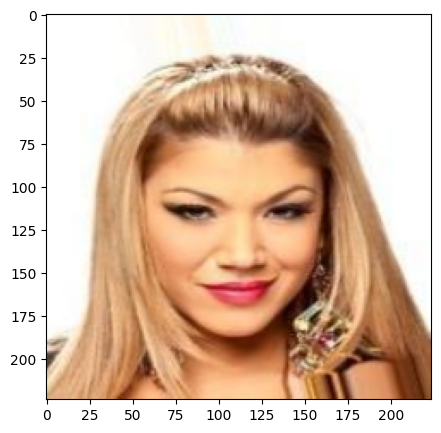

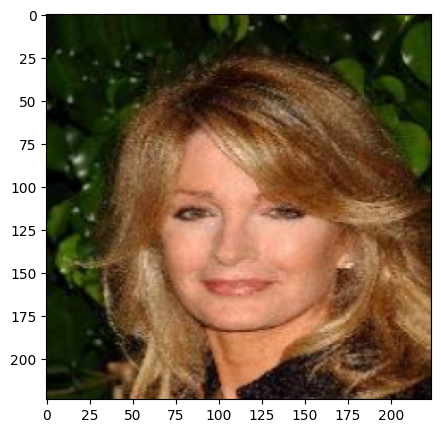

tensor(-1)


In [ ]:
# Testing the dataset
batch = next(iter(train_dl))
print(batch['pixel_values_1'].shape,batch['pixel_values_1'].shape, batch['labels'].shape)
imgshow(torchvision.utils.make_grid(batch['pixel_values_1'][0]))
imgshow(torchvision.utils.make_grid(batch['pixel_values_2'][0]))
print(batch['labels'][0])

In [ ]:
batch

{'pixel_values_1': tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           ...,
           [ 0.5686,  0.5451,  0.5765,  ...,  0.0353,  0.1059,  0.1294],
           [ 0.6235,  0.6235,  0.6784,  ..., -0.0118,  0.0667,  0.1059],
           [ 0.6314,  0.6235,  0.6863,  ..., -0.0118,  0.0667,  0.1059]],
 
          [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           ...,
           [ 0.3176,  0.2941,  0.2863,  ..., -0.3882, -0.3333, -0.3255],
           [ 0.3725,  0.3490,  0.3725,  ..., -0.4431, -0.3725, -0.3490],
           [ 0.3647,  0.3412,  0.3725,  ..., -0.4431, -0.3725, -0.3490]],
 
          [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.00

In [ ]:
batch['pixel_values_1'][0]

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 0.5686,  0.5451,  0.5765,  ...,  0.0353,  0.1059,  0.1294],
         [ 0.6235,  0.6235,  0.6784,  ..., -0.0118,  0.0667,  0.1059],
         [ 0.6314,  0.6235,  0.6863,  ..., -0.0118,  0.0667,  0.1059]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 0.3176,  0.2941,  0.2863,  ..., -0.3882, -0.3333, -0.3255],
         [ 0.3725,  0.3490,  0.3725,  ..., -0.4431, -0.3725, -0.3490],
         [ 0.3647,  0.3412,  0.3725,  ..., -0.4431, -0.3725, -0.3490]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1

# Model Training

In [ ]:
torch.cuda.empty_cache()

In [ ]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 1000, # set to very high number
    "seed": 42,
    "patience": 10, # early stopping
    "output_dir_pt": f"{gdrive_path}/vit_celebA_gpu_pt_1.pt",
    "output_dir_transformer": f"{gdrive_path}/vit_celebA_gpu_pt_1",
    #'dropout_rate': 0.2,
    #'num_dense_layers': 6,
    #'hidden_dim': 16
}


In [ ]:
## Creating NN Layer
#class FaceEmbeddingModel(torch.nn.Module):
#    def __init__(self, model_name, embedding_size):
#        super(FaceEmbeddingModel, self).__init__()
#        self.config = ViTConfig.from_pretrained(model_name, id2label=idx_to_label, label2id=label_to_idx, return_dict=True)
#        self.backbone = ViTModel.from_pretrained(model_name, config=self.config)  # Load ViT model
#        #self.fc = torch.nn.Linear(197*self.backbone.config.hidden_size, 1) # Convert to 512D feature vector
#        #self.relu = torch.nn.ReLU()
#        self.ff_head = torch.nn.Linear(self.backbone.config.hidden_size, embedding_size)
#
#    def forward(self, images):
#        x = self.backbone(images).last_hidden_state[:, 0]  # Extract embeddings
#        self.backbone.gradient_checkpointing_enable()
#        # Freeze the backbone
#        for param in self.backbone.parameters():
#            param.requires_grad = False
#
#        #x = torch.flatten(x, start_dim=1) # Newly added
#        #x = self.fc(x)  # Convert to 512D embedding
#        #x = self.relu(x)
#        x = self.ff_head(x)
#        x = torch.nn.functional.normalize(x)  # Normalize for cosine similarity
#        return x

In [ ]:
## Creating Loss function
#class ContrastiveLoss(torch.nn.Module):
#    def __init__(self, margin=1.0):
#        super(ContrastiveLoss, self).__init__()
#        self.margin = margin
#
#    def forward(self, emb1, emb2, label):
#        distance = F.pairwise_distance(emb1, emb2)
#        loss = (1 - label) * distance**2 + label * F.relu(self.margin - distance) ** 2
#        return loss.mean()

In [ ]:
# Now we train the model
def training_function():
    # Initialize accelerator
    accelerator = Accelerator()

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    #if accelerator.is_main_process:
    #    datasets.utils.logging.set_verbosity_warning()
    #    transformers.utils.logging.set_verbosity_info()
    #else:
    #    datasets.utils.logging.set_verbosity_error()
    #    transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Instantiate the model, chnage the final classification layer, let Accelerate handle the device placement.
    #embedding_model = FaceEmbeddingModel(MODEL_TRANSFORMER, EMBEDDING_SIZE)
    config = ViTConfig.from_pretrained(MODEL_TRANSFORMER ,return_dict=True)
    embedding_model = ViTModel.from_pretrained(MODEL_TRANSFORMER, config=config)

    ## Final Classification Layer
    #embedding_model.classifier = torch.nn.Linear(embedding_model.config.hidden_size, EMBEDDING_SIZE)

    # Freeze all layers
    for param in embedding_model.parameters():
        param.requires_grad = False

    # Unfreeze the last layer
    for param in embedding_model.encoder.layer[-1].parameters():  # Last transformer block
        param.requires_grad = True

    # Loss function
    criterion = CosineEmbeddingLoss(margin=0.25)

    # Instantiate optimizer
    optimizer = AdamW(embedding_model.parameters(), lr=hyperparameters["learning_rate"])

    # Define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True, min_lr=0.00001
    )

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_criterion ,acclerated_optimizer, acclerated_train_dl, acclerated_val_dl = accelerator.prepare(embedding_model, criterion, optimizer, train_dl, val_dl)

    # Build the training loop
    epochs_no_improve = 0
    min_val_loss = float("inf")

    for epoch in range(hyperparameters["num_epochs"]):
      # We only enable the progress bar on the main process to avoid having 8 progress bars.
      progress_bar = tqdm(range(len(acclerated_train_dl)), disable=not accelerator.is_main_process)
      progress_bar.set_description(f"Epoch: {epoch}")
      accelerated_model.train()
      training_loss = []
      for batch in acclerated_train_dl:
          # Forward pass
          img1 = batch['pixel_values_1']
          img2 = batch['pixel_values_2']
          label = batch['labels']

          # Extract embeddings
          out1 = accelerated_model(img1)
          emb1 = out1.last_hidden_state[:, 0, :]

          out2 = accelerated_model(img2)
          emb2 = out2.last_hidden_state[:, 0, :]

          # Compute loss
          train_loss = acclerated_criterion(emb1, emb2, label)

          # Backward pass
          accelerator.backward(train_loss)

          # Optimize
          acclerated_optimizer.step()
          acclerated_optimizer.zero_grad()

          # We gather the loss from the GPU cores to have them all.
          training_loss.append(accelerator.gather(train_loss[None]))
          progress_bar.set_postfix({'loss': train_loss.item()})
          progress_bar.update(1)

      # Compute average training loss
      training_loss_final = torch.stack(training_loss).sum().item() / len(training_loss)
      # Use accelerator.print to print only on the main process.
      accelerator.print(f"epoch {epoch}: learning rate:", scheduler.get_last_lr())
      accelerator.print(f"epoch {epoch}: training loss:", training_loss_final)

      # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
      accelerated_model.eval()
      validation_loss = []

      for batch in acclerated_val_dl:
          # Forward pass
          img1 = batch['pixel_values_1']
          img2 = batch['pixel_values_2']
          label = batch['labels']

          with torch.no_grad():
              out1 = accelerated_model(img1)
              emb1 = out1.last_hidden_state[:, 0, :]

              out2 = accelerated_model(img2)
              emb2 = out2.last_hidden_state[:, 0, :]

          val_loss = acclerated_criterion(emb1, emb2, label)

          # We gather the loss from the GPU cores to have them all.
          validation_loss.append(accelerator.gather(val_loss[None]))

      # Compute average validation loss
      validation_loss_final = torch.stack(validation_loss).sum().item() / len(validation_loss)
      # Use accelerator.print to print only on the main process.
      accelerator.print(f"epoch {epoch}: validation loss:", validation_loss_final)

      # Step the scheduler
      scheduler.step(validation_loss_final)

      # Save model with early stopping
      if validation_loss_final < min_val_loss:
          epochs_no_improve = 0
          min_val_loss = validation_loss_final
          # Save the entire model (including architecture and weights)
          torch.save(accelerated_model, hyperparameters['output_dir_pt'])
          accelerated_model.save_pretrained(hyperparameters['output_dir_transformer'])
          continue
      else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == hyperparameters["patience"]:
          accelerator.print("Early stopping!")
          break

    # Close the writer after training
    #writer.close()

In [ ]:
# Run the trainer function
training_function()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6250 [00:00<?, ?it/s]

# Load model

In [ ]:
model_pretrained = torch.load(hyperparameters['output_dir_pt'])
model_pretrained.eval()
print("Entire model loaded successfully!")

<ipython-input-55-b07e17ccb29b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_pretrained = torch.load(hyperparameters['output_dir_pt'])


Entire model loaded successfully!


# PROD

In [ ]:
prod_image = torch.rand(1, 3, 224, 224)  # Dummy image tensor

torch.Size([64, 3, 224, 224]) torch.Size([64])


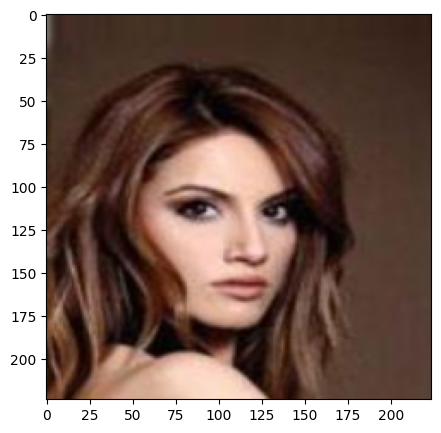

In [ ]:
# Testing the dataset
batch = next(iter(val_dl))
print(batch['images'].shape, batch['labels'].shape)
imgshow(torchvision.utils.make_grid(batch['images'][0]))

In [ ]:
model_pretrained.eval()
with torch.no_grad():
  prod_outputs = model_pretrained(batch['images'][:4].to(device))

AttributeError: 'Tensor' object has no attribute 'hidden_states'

In [ ]:
batch['labels'][:4]

tensor([ 946,   17, 1200, 1197])

In [ ]:
prod_outputs

tensor([[-2.0264, -1.5300, -2.6107,  ..., -3.1700, -3.4884,  0.4853],
        [ 0.9893, -1.3535, -1.3744,  ..., -3.9707, -4.4145, -2.1332],
        [-1.4478,  0.3926,  1.1496,  ..., -3.0401, -2.7123,  0.5069],
        [ 0.5516,  0.3590,  1.3405,  ..., -3.5127, -3.3352, -0.5587]],
       device='cuda:0')

In [ ]:
prod_outputs.argmax(1)

tensor([ 249, 1336,  417, 1044], device='cuda:0')

# Model Testing - TEST Data

In [ ]:
test_ds = dataset_obj.create_dataset(identity_df=combined_small_df[combined_small_df['partition']==2])
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

0it [00:00, ?it/s]

RuntimeError: stack expects a non-empty TensorList

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
# Now we train the model
def testing_function():
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    #if accelerator.is_main_process:
    #    datasets.utils.logging.set_verbosity_warning()
    #    transformers.utils.logging.set_verbosity_info()
    #else:
    #    datasets.utils.logging.set_verbosity_error()
    #    transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Load the model
    model_pretrained = torch.load(hyperparameters['output_dir_pt'])

    # Loss function
    criterion = ContrastiveLoss()

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_criterion, acclerated_test_dl = accelerator.prepare(model_pretrained, criterion, val_dl)

    # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
    accelerated_model.eval()

    test_labels = []
    test_preds = []

    for batch in tqdm(acclerated_test_dl):

        img1 = batch['pixel_values_1']
        img2 = batch['pixel_values_2']
        label = batch['labels']

        with torch.no_grad():
            emb1 = accelerated_model(img1)
            emb2 = accelerated_model(img2)

        test_loss = acclerated_criterion(emb1, emb2, label)

        test_preds.append(test_loss)
        test_labels.append(label)

        #test_preds = torch.cat(test_pred)
        #test_labels = torch.cat(test_label)
    return test_labels, test_preds


In [ ]:
actual_label, predicted_test_label = testing_function()

<ipython-input-103-f0bc432f2bd1>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_pretrained = torch.load(hyperparameters['output_dir_pt'])


  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
predicted_test_label

[tensor(0.0668, device='cuda:0'),
 tensor(0.0843, device='cuda:0'),
 tensor(0.0377, device='cuda:0'),
 tensor(0.0735, device='cuda:0'),
 tensor(0.0507, device='cuda:0'),
 tensor(0.0502, device='cuda:0'),
 tensor(0.0792, device='cuda:0'),
 tensor(0.0682, device='cuda:0'),
 tensor(0.0630, device='cuda:0'),
 tensor(0.0637, device='cuda:0'),
 tensor(0.0508, device='cuda:0'),
 tensor(0.0810, device='cuda:0'),
 tensor(0.0719, device='cuda:0'),
 tensor(0.0672, device='cuda:0'),
 tensor(0.0818, device='cuda:0'),
 tensor(0.0648, device='cuda:0'),
 tensor(0.0426, device='cuda:0'),
 tensor(0.0333, device='cuda:0'),
 tensor(0.1451, device='cuda:0'),
 tensor(0.1119, device='cuda:0'),
 tensor(0.0560, device='cuda:0'),
 tensor(0.0288, device='cuda:0'),
 tensor(0.0634, device='cuda:0'),
 tensor(0.1121, device='cuda:0'),
 tensor(0.0594, device='cuda:0'),
 tensor(0.0366, device='cuda:0'),
 tensor(0.0507, device='cuda:0'),
 tensor(0.0703, device='cuda:0'),
 tensor(0.0531, device='cuda:0'),
 tensor(0.0293

In [ ]:
actual_labels = torch.cat(actual_label, 0).to('cpu')
predicted_test_labels = torch.cat(predicted_test_label,0).to('cpu')

RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

In [ ]:
actual_label

[tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8),
 tenso

In [ ]:
len(predicted_test_label)

125

In [ ]:
predicted_test_label.numpy()

AttributeError: 'list' object has no attribute 'numpy'

In [ ]:
len(actual_labels)

1000

In [ ]:
print(classification_report(actual_labels.numpy(),
                            predicted_test_labels.numpy(),
                            ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      0.75      0.86         4
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      0.50      0.67         4
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         3
          11       0.50      1.00      0.67         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         3
          15       0.67      1.00      0.80         4
          16       0.20      0.33      0.25         3
          17       1.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
